In [ ]:
import sys

sys.path.append('../soft/')
sys.path.append('../firmware/')

from qick import *
from qick_training import *
from qick.averager_program import QickSweep
from qick.averager_program import QickRegister
from qick.averager_program import merge_sweeps

import numpy as np
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt

In [ ]:
# Load bitstream with custom overlay
soc = QickSoc('../firmware/qick_training.bit')
soccfg = soc

print(soccfg)

## Phase Control Tests
This example uses 1 or 2 signal generator blocks to show different ways of controlling the phase. Examples include:
1. One signal generator, with phase reset flag.
2. One signal generator, with phase reset and initial phase.
3. Two signal generators, with phase sync and frequency jump.
4. Two signal generators, phase jump between pulses.

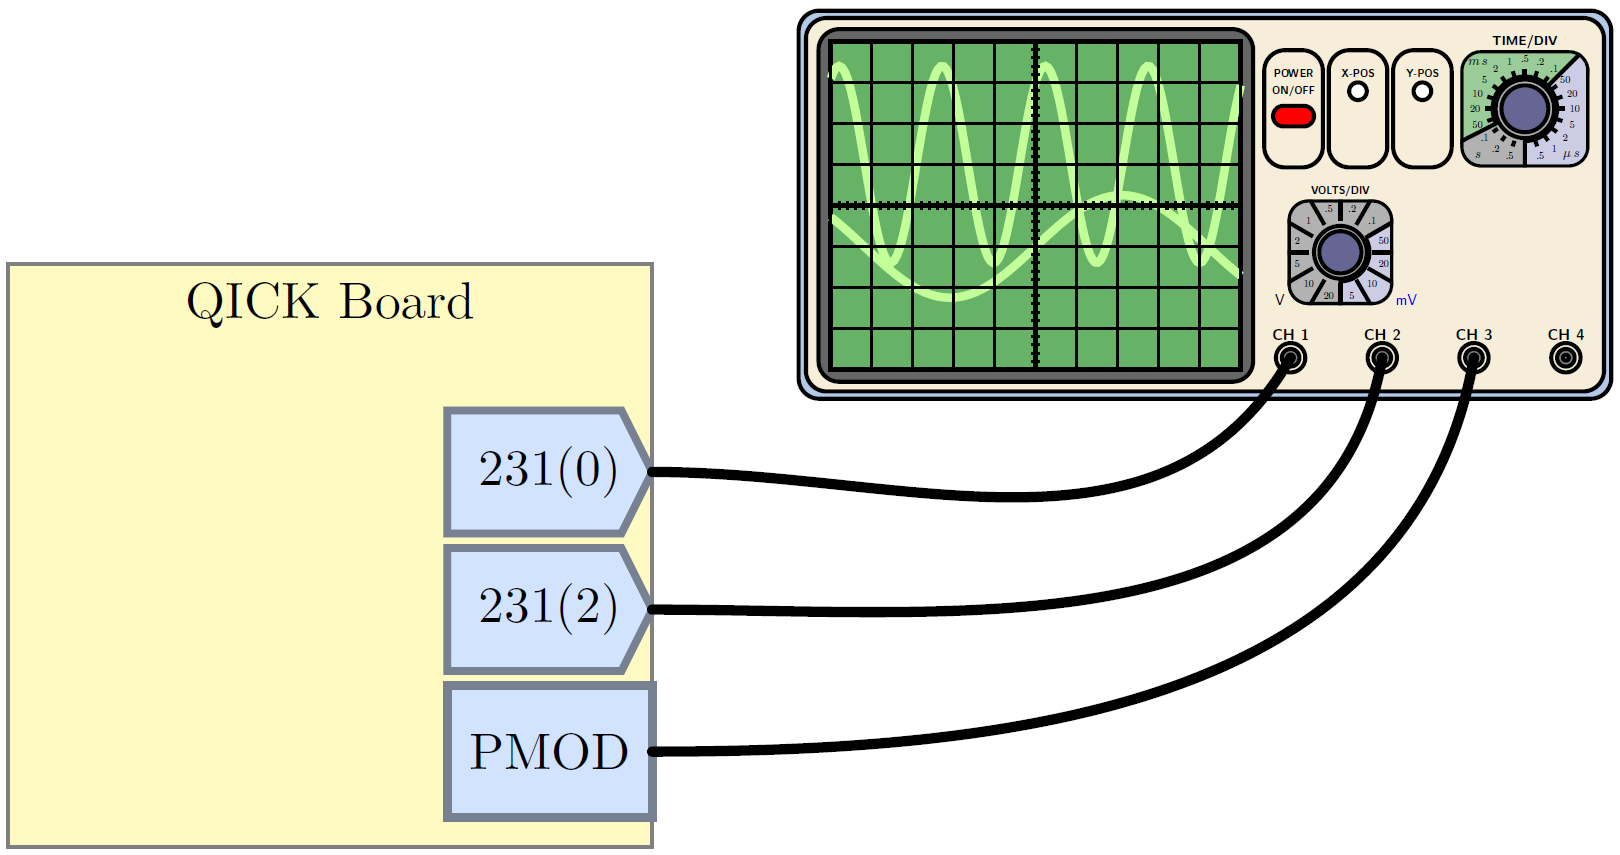

In [4]:
from IPython.display import Image, display
display(Image(filename='images/connections_demo00_demo01.png', embed=True))

In [ ]:
#########################################
### Phse Reset Flag, single generator ###
#########################################
class PhaseTest(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1)        
        
        # First channel.
        self.default_pulse_registers(ch     = self.cfg['gen_ch'], 
                                     style  = 'const', 
                                     freq   = self.freq2reg(self.cfg['pulse_freq'],gen_ch=self.cfg['gen_ch']),
                                     phase  = 0,
                                     gain   = self.cfg['pulse_gain'], 
                                     length = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch']))   
        
        self.synci(200)
    
    def body(self):
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'], 
                                 phrst=self.cfg['phrst'], 
                                 mode="oneshot")
        # Trigger.
        self.trigger(pins=[0],t=40)

        # Pulses.
        self.pulse(ch=self.cfg['gen_ch'])
        
        # Period.
        self.synci(self.us2cycles(self.cfg['period']))
       
config={"gen_ch"      : 4,
        "reps"        : 3,
        "pulse_length": 1.2,
        "pulse_gain"  : 30000,
        "pulse_freq"  : 10.4,
        "period"      : 2,
        "phrst"       : 1,
       }

prog = PhaseTest(soccfg, config)
prog.config_all(soccfg)
soc.tproc.start()

In [ ]:
####################################################
### Phase reset and initial phase, one generator ###
####################################################
class PhaseTest(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1)        
        
        # First channel.
        self.default_pulse_registers(ch     = self.cfg['gen_ch'], 
                                     style  = 'const', 
                                     freq   = self.freq2reg(self.cfg['pulse_freq'],gen_ch=self.cfg['gen_ch']),
                                     phrst  = self.cfg['phrst'],
                                     gain   = self.cfg['pulse_gain'], 
                                     length = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch']))   
        
        self.synci(200)
    
    def body(self):        
        # Trigger.
        self.trigger(pins=[0],t=40,width=100)

        # First pulse.
        self.set_pulse_registers(ch=self.cfg['gen_ch'], phase=0)        
        self.pulse(ch=self.cfg['gen_ch'])
        
        # Wait.
        self.synci(self.us2cycles(0.2*self.cfg['pulse_length']))
        
        # Second pulse.
        phase = self.deg2reg(self.cfg['phase_jump'],gen_ch=self.cfg['gen_ch'])
        self.set_pulse_registers(ch=self.cfg['gen_ch'], phase=phase)
        self.pulse(ch=self.cfg['gen_ch'])
        
        # Wait.
        self.synci(self.us2cycles(1.2*self.cfg['pulse_length']))
       
config={"gen_ch"      : 4,
        "reps"        : 1,
        "pulse_length": 1.2,
        "pulse_gain"  : 30000,
        "pulse_freq"  : 10.4,
        "phase_jump"  : 0,
        "phrst"       : 1,
       }

prog = PhaseTest(soccfg, config)
prog.config_all(soccfg)
soc.tproc.start()

In [ ]:
#####################################################
### Two generators, phase sync and frequency jump ###
#####################################################
class PhaseTest(NDAveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"][0], nqz=1)
        self.declare_gen(ch=self.cfg["gen_ch"][1], nqz=1)
        
        # First channel.
        self.default_pulse_registers(ch     = self.cfg['gen_ch'][0], 
                                     style  = 'const', 
                                     freq   = self.freq2reg(self.cfg['pulse_freq'][0],gen_ch=self.cfg['gen_ch'][0]),
                                     gain   = self.cfg['pulse_gain'][0],
                                     phase  = 0,
                                     length = self.us2cycles(self.cfg['pulse_length'][0],gen_ch=self.cfg['gen_ch'][0]))
        
        # Second channel.
        self.default_pulse_registers(ch     = self.cfg['gen_ch'][1], 
                                     style  = 'const', 
                                     freq   = self.freq2reg(self.cfg['pulse_freq'][1],gen_ch=self.cfg['gen_ch'][1]),
                                     gain   = self.cfg['pulse_gain'][1],
                                     phase  = 0,
                                     length = self.us2cycles(self.cfg['pulse_length'][1],gen_ch=self.cfg['gen_ch'][1]))
        
        # Get frequency register.
        self.reg_f = self.get_gen_reg(self.cfg['gen_ch'][1], 'freq')
        
        # Define a QickRegister for the original value.
        self.reg_f_orig = QickRegister(self, self.reg_f.page, 20, name = "f_orig")
        self.reg_f_orig.set_to(self.reg_f)
        
        # Define a QickRegister for the jump.
        self.reg_f_jump = QickRegister(self, self.reg_f.page, 21, name = "f_jump")
        self.reg_f_jump.set_to(self.freq2reg(self.cfg['freq_jump'], gen_ch=self.cfg['gen_ch'][1]))
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # Trigger.
        self.trigger(pins=[0],t=40,width=100)
        
        # Pulses (reset phase).
        self.set_pulse_registers(ch=self.cfg['gen_ch'][0],phrst=1)
        self.set_pulse_registers(ch=self.cfg['gen_ch'][1],phrst=1)
        self.pulse(ch = self.cfg['gen_ch'][0])
        self.pulse(ch = self.cfg['gen_ch'][1])
        
        # Wait, Jump and send Pulse (don't reset phase).
        self.synci(self.us2cycles(self.cfg['wait']))
        self.reg_f.set_to(self.reg_f_jump)
        self.set_pulse_registers(ch=self.cfg['gen_ch'][1],phrst=0)
        self.pulse(ch = self.cfg['gen_ch'][1])
        
        # Wait, Jump and send Pulse.
        self.synci(self.us2cycles(self.cfg['wait']))
        self.reg_f.set_to(self.reg_f_orig)        
        self.pulse(ch = self.cfg['gen_ch'][1])
        
        # Period.
        self.synci(self.us2cycles(self.cfg['period']))
       
config={"gen_ch"      : [4,5],
        "reps"        : 2,
        "pulse_length": [2,0.5],
        "pulse_gain"  : [30000,30000], # [DAC units]
        "pulse_freq"  : [10,10], # [MHz]
        "freq_jump"   : 77,
        "wait"        : 0.2,
        "period"      : 3,
       }

prog = PhaseTest(soccfg, config)
prog.config_all(soccfg)
soc.tproc.start()

In [ ]:
#################################################
### Two generators, phase jump between pulses ###
#################################################
class PhaseTest(NDAveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"][0], nqz=1)
        self.declare_gen(ch=self.cfg["gen_ch"][1], nqz=1)
        
        # First channel.
        self.default_pulse_registers(ch     = self.cfg['gen_ch'][0], 
                                     style  = 'const', 
                                     freq   = self.freq2reg(self.cfg['pulse_freq'][0],gen_ch=self.cfg['gen_ch'][0]),
                                     gain   = self.cfg['pulse_gain'][0],
                                     phrst  = 0,
                                     length = self.us2cycles(self.cfg['pulse_length'][0],gen_ch=self.cfg['gen_ch'][0]))
        
        # Second channel.
        self.default_pulse_registers(ch     = self.cfg['gen_ch'][1], 
                                     style  = 'const', 
                                     freq   = self.freq2reg(self.cfg['pulse_freq'][1],gen_ch=self.cfg['gen_ch'][1]),
                                     gain   = self.cfg['pulse_gain'][1],
                                     phrst  = 0,
                                     length = self.us2cycles(self.cfg['pulse_length'][1],gen_ch=self.cfg['gen_ch'][1]))
        
        # Get phase register.
        self.reg_ph = self.get_gen_reg(self.cfg['gen_ch'][1], 'phase')
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'][0],phase=0)
        self.set_pulse_registers(ch=self.cfg['gen_ch'][1],phase=0)

        # Trigger.
        self.trigger(pins=[0],t=40,width=100)
        
        # Pulses.
        self.pulse(ch = self.cfg['gen_ch'][0])
        self.pulse(ch = self.cfg['gen_ch'][1])
        
        # Increment phase and send Pulse.        
        self.reg_ph.set_to(self.reg_ph, "+", self.cfg['phase_inc'])
        self.pulse(ch = self.cfg['gen_ch'][1])
        
        # Increment phase and send Pulse.        
        self.reg_ph.set_to(self.reg_ph, "+", self.cfg['phase_inc'])
        self.pulse(ch = self.cfg['gen_ch'][1])
        
        # Increment phase and send Pulse.        
        self.reg_ph.set_to(self.reg_ph, "+", self.cfg['phase_inc'])
        self.pulse(ch = self.cfg['gen_ch'][1])
        
        # Increment phase and send Pulse.        
        self.reg_ph.set_to(self.reg_ph, "+", self.cfg['phase_inc'])
        self.pulse(ch = self.cfg['gen_ch'][1])
        
        # Set phase back to 0..        
        self.set_pulse_registers(ch=self.cfg['gen_ch'][1],phase=0)
        self.pulse(ch = self.cfg['gen_ch'][1])     
        
        # Period.
        self.synci(self.us2cycles(self.cfg['period']))
       
config={"gen_ch"      : [4,5],
        "reps"        : 1,
        "pulse_length": [7,1],
        "pulse_gain"  : [30000,30000], # [DAC units]
        "pulse_freq"  : [10,10], # [MHz]
        "phase_inc"   : 45,
        "period"      : 10,
       }

prog = PhaseTest(soccfg, config)
prog.config_all(soccfg)
soc.tproc.start()

In [ ]:
print(prog)